C:\Users\Shinichi\AppData\Local\Temp/ipykernel_12924/2948886483.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


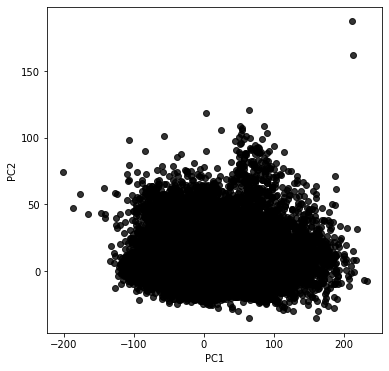

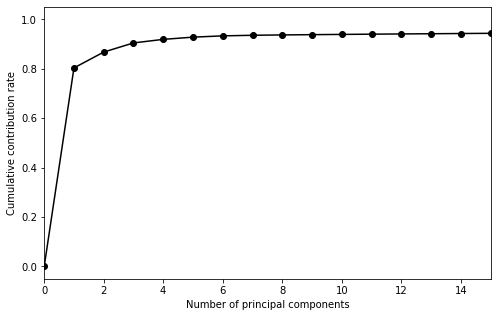

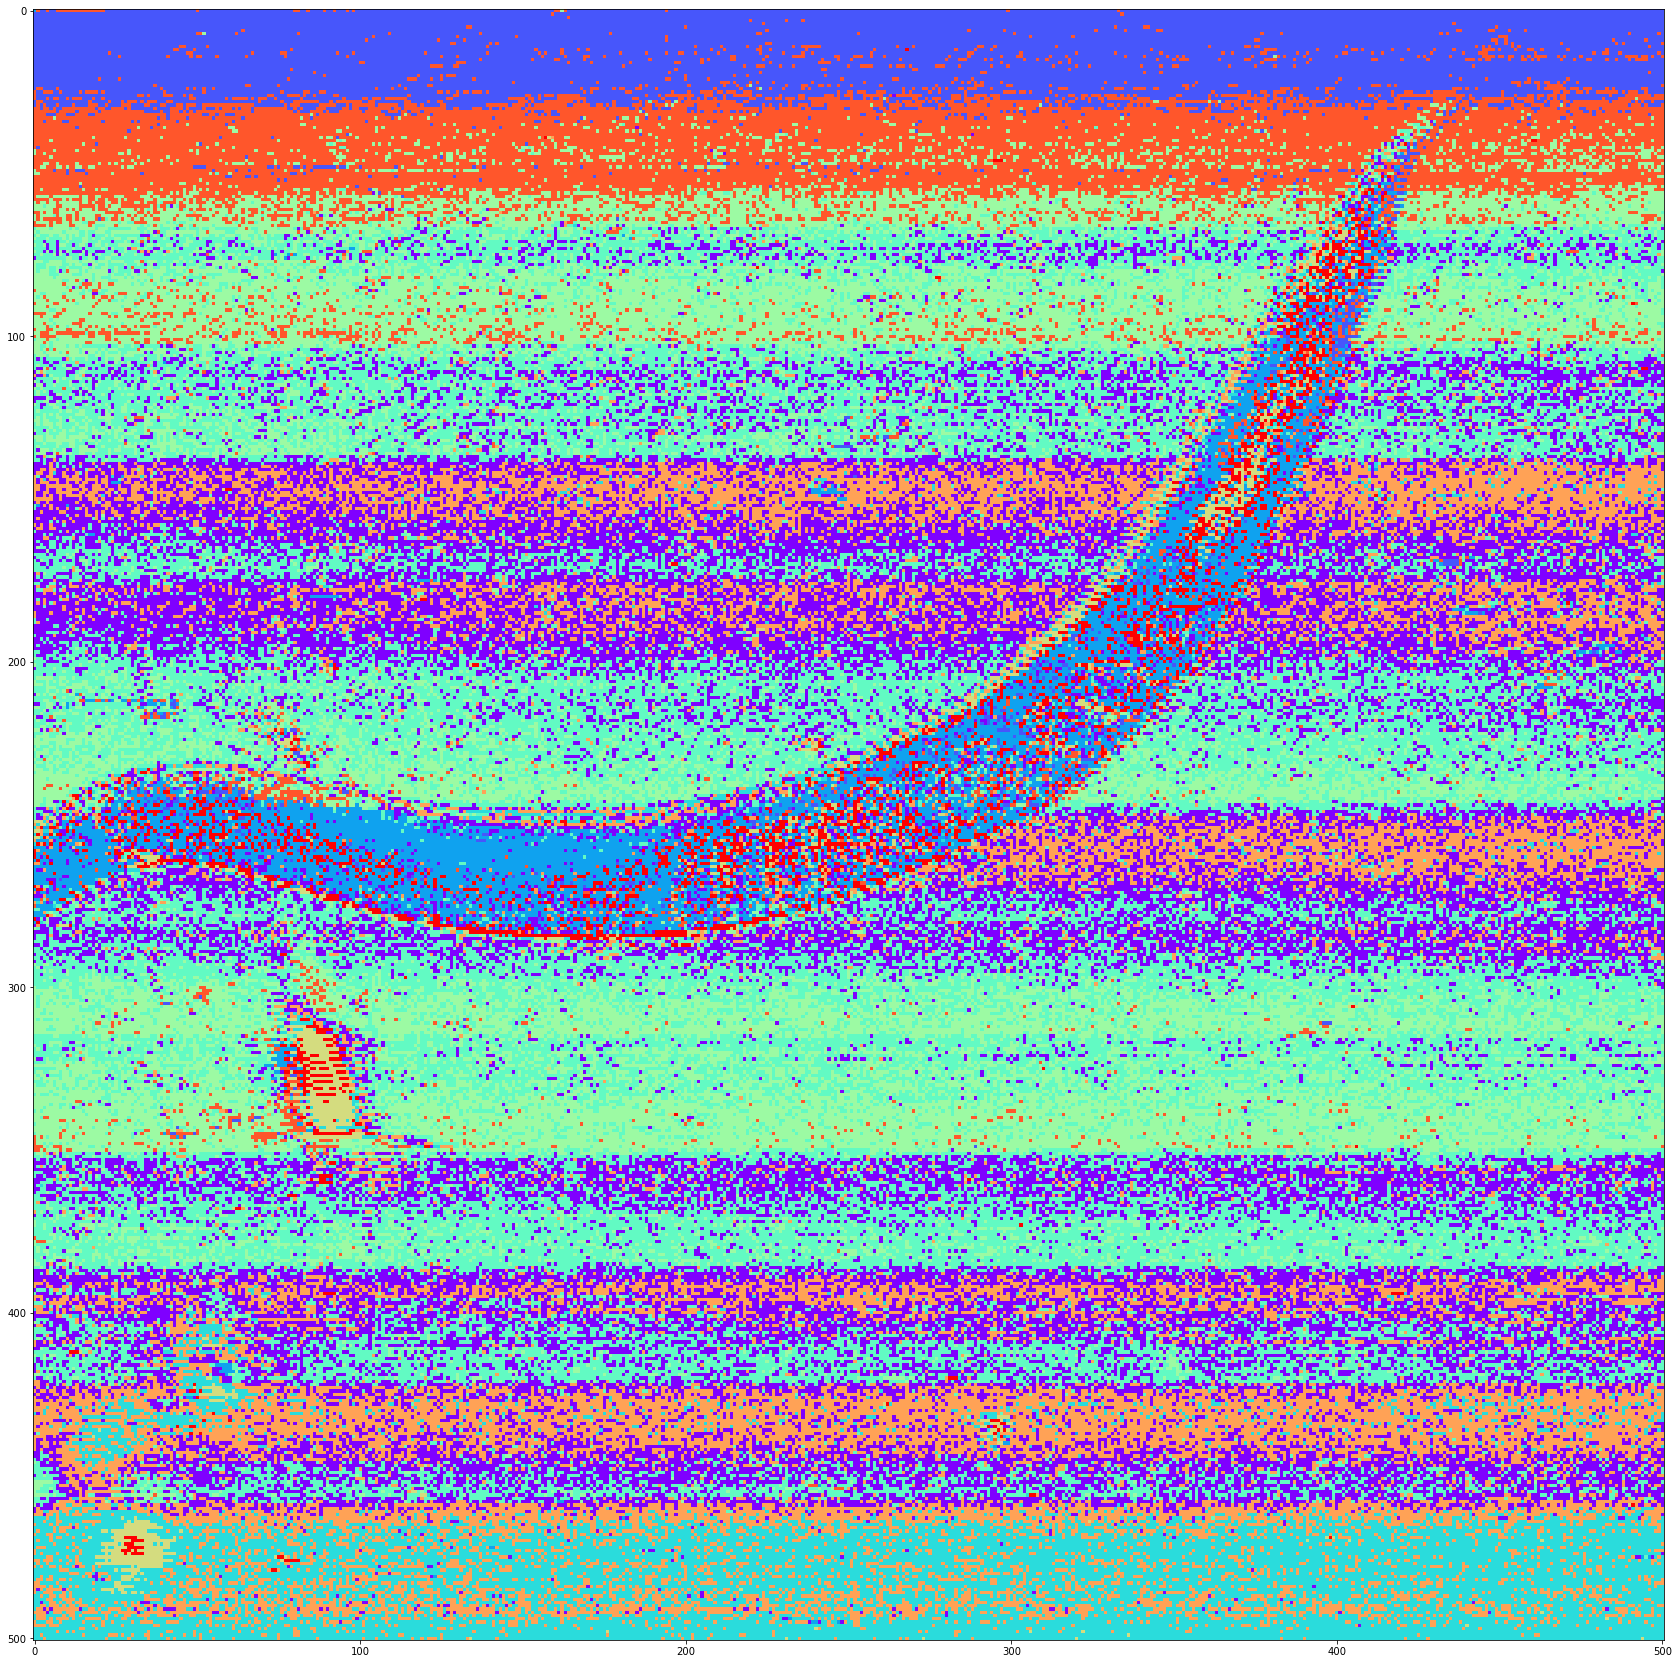

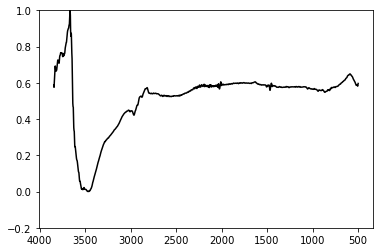

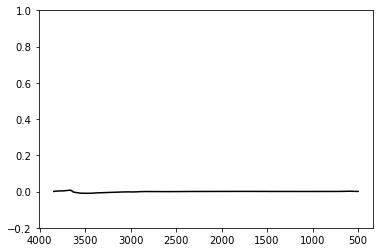

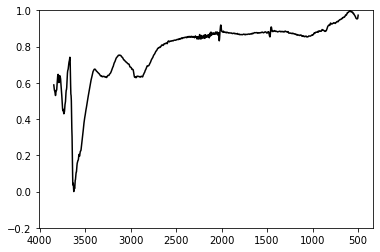

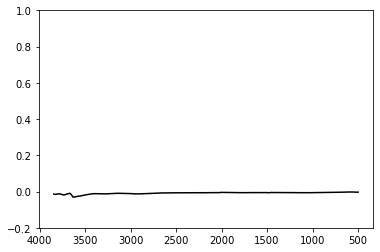

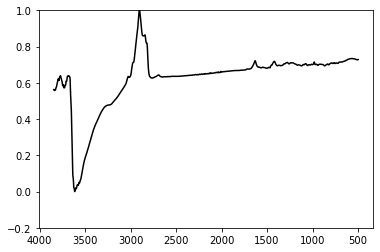

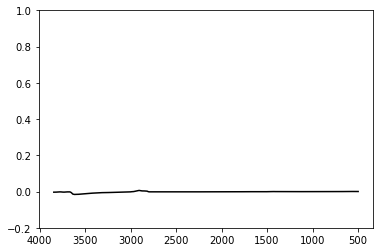

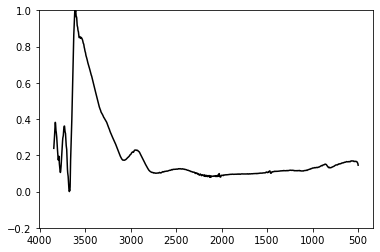

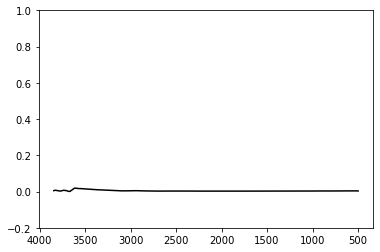

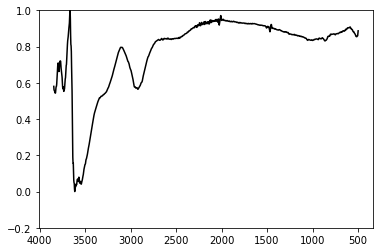

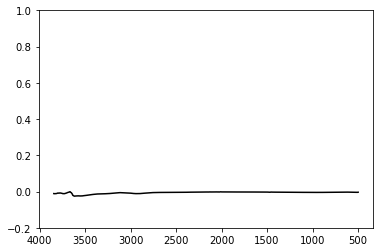

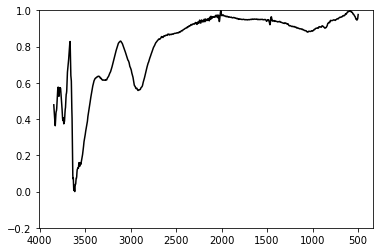

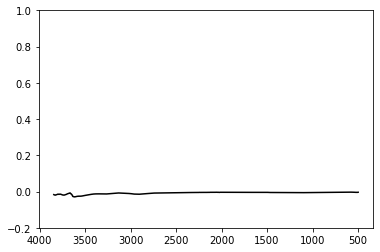

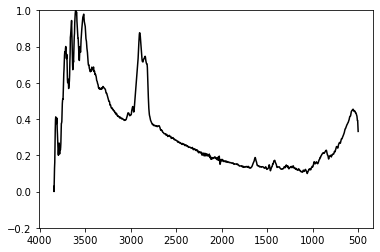

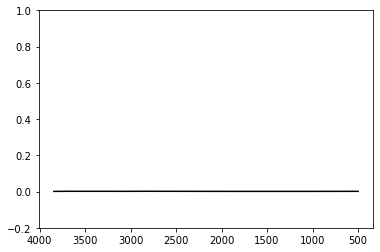

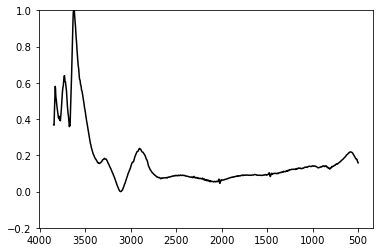

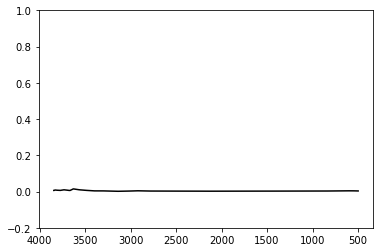

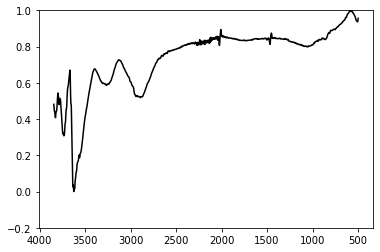

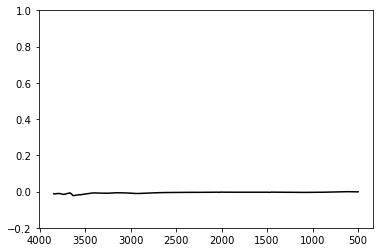

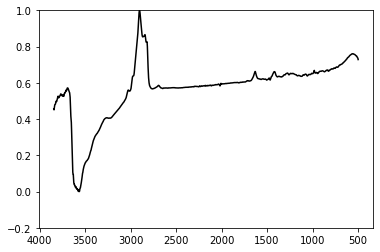

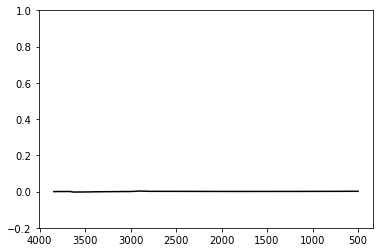

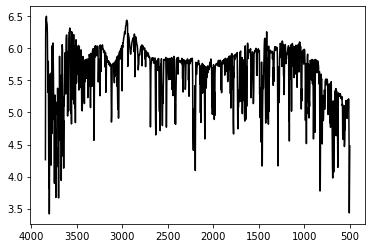

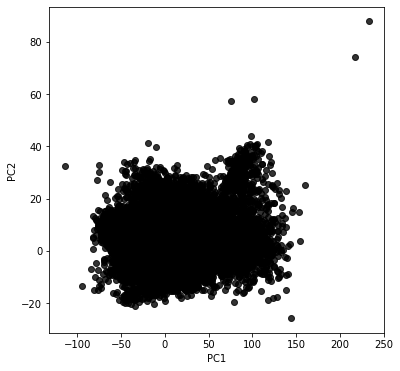

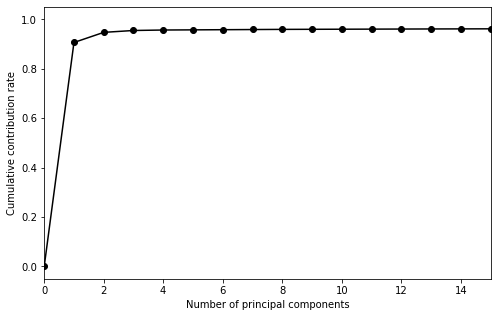

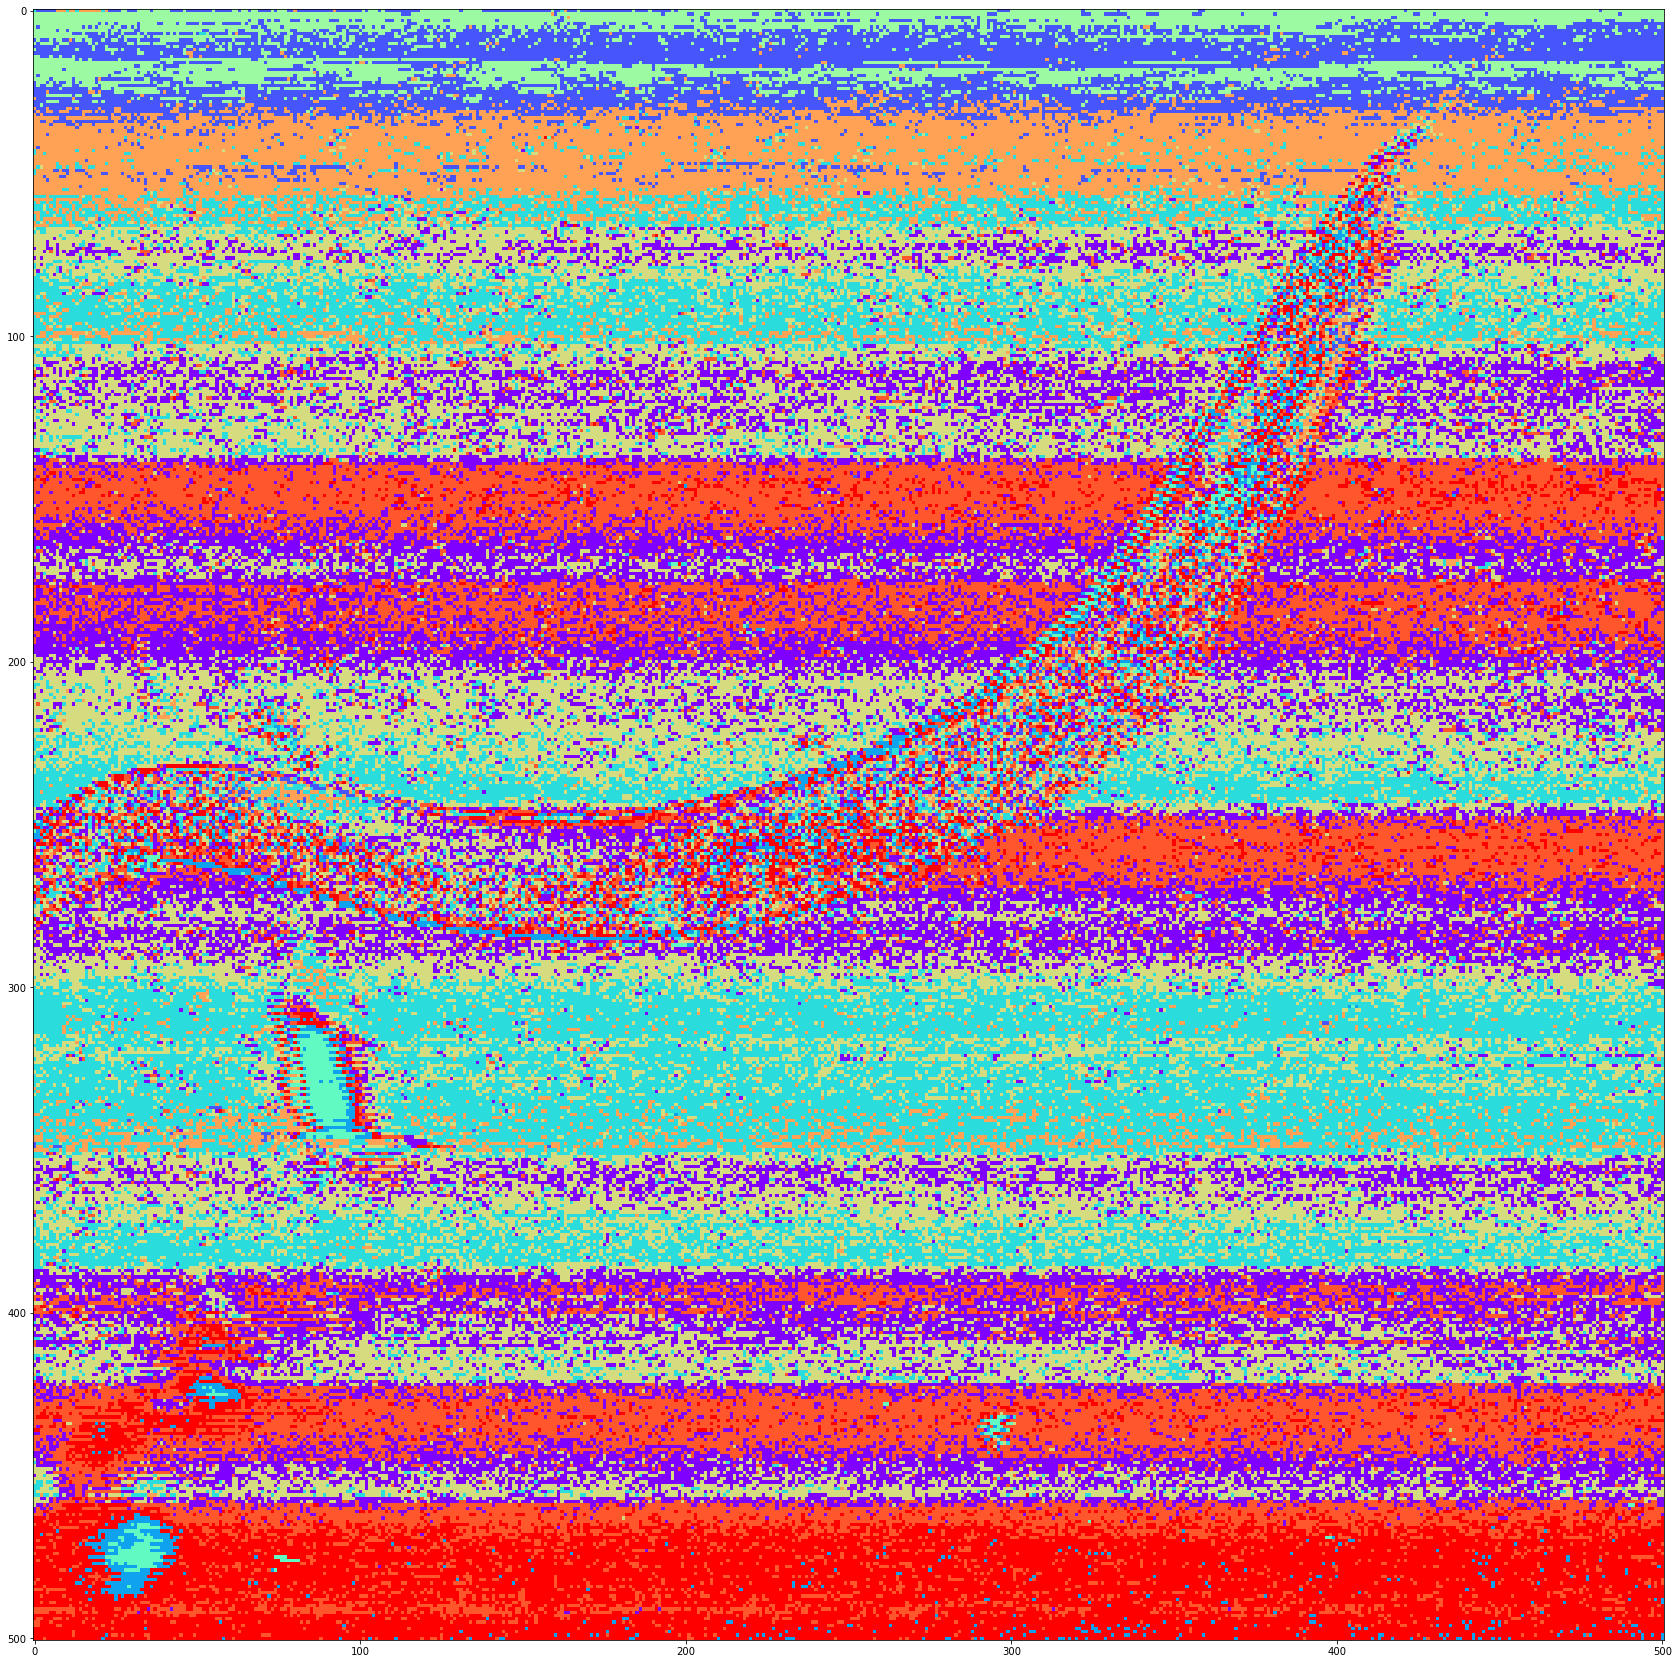

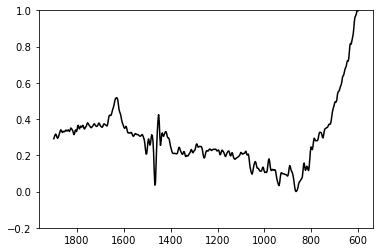

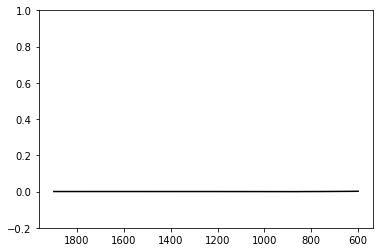

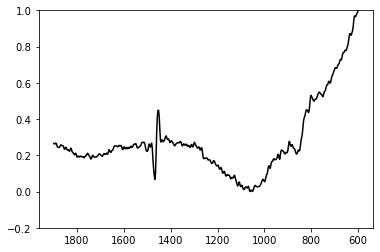

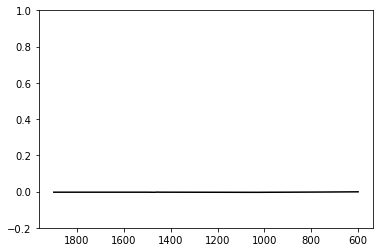

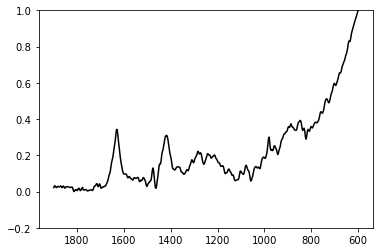

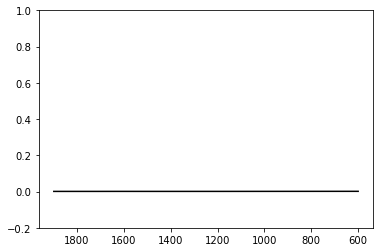

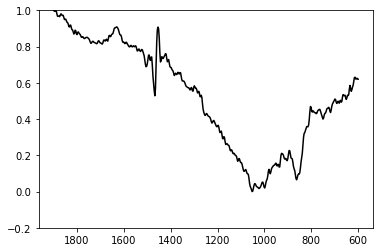

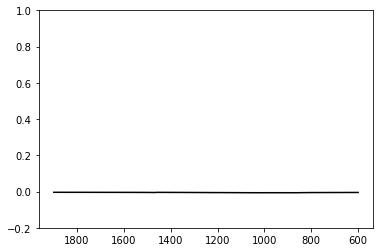

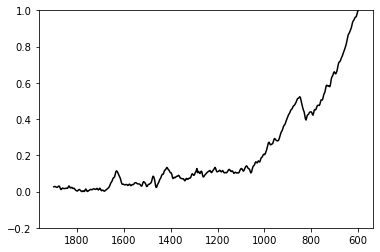

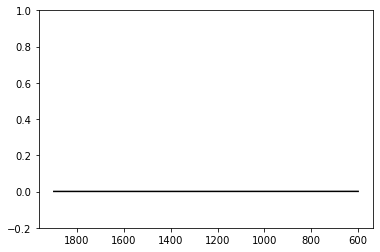

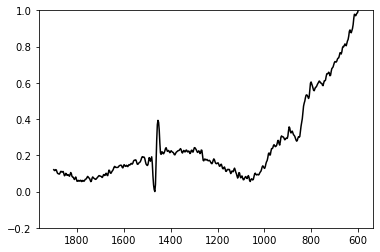

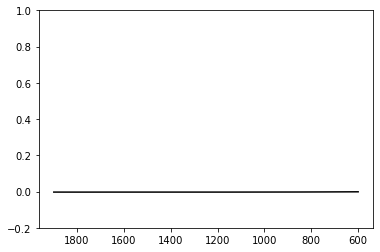

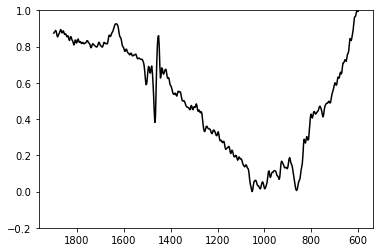

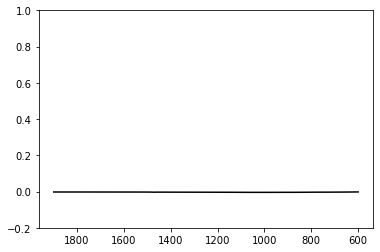

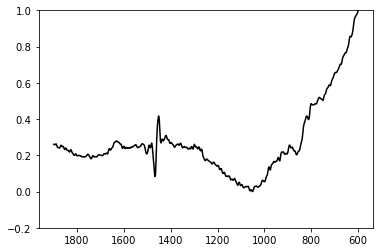

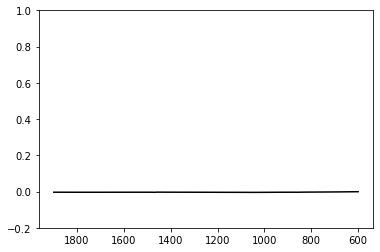

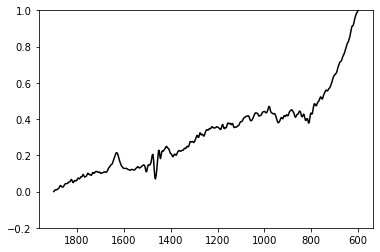

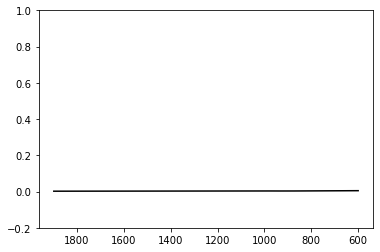

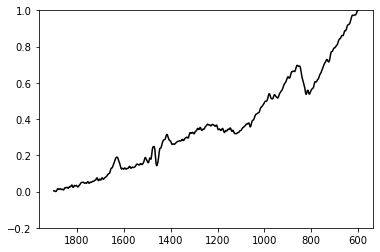

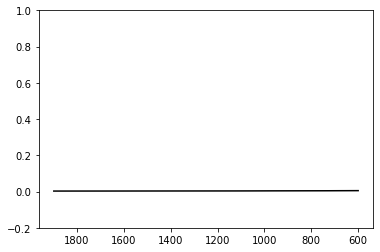

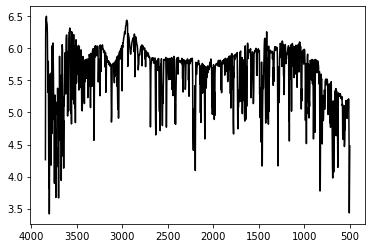

In [1]:
# moduleのインポート
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans


# データのパス
data_path = "C:/Users/Shinichi/Desktop/20220405/imchi3_2d.csv"
# 横軸のパス
axis_path = "C:/Users/Shinichi/Desktop/20220405/re_ramanshift2.csv"

# PCA後のデータをいくつのクラスターに分けるか
cluster_num = 10
# データの縦幅
x = 501
# データの横幅
y = 501
# 詳細に解析する波数範囲 (指紋領域用にしています)
subrange = (600, 1900)

def normalization(data_array):
    """
    normalize the data array within 0~255
    :param data_array: numpy array
    :return: data_array: numpy array (overwrite)
    """
    amin = np.amin(data_array)
    amax = np.amax(data_array)
    scale = 255.0 / (amax - amin)
    data_array = data_array - amin
    data_array = data_array * scale
    data_array = np.uint8(data_array)
    return data_array


def calc_entropy(tempdata):
    """
    :param tempdata: numpy array
    :return: entropy: float32, entropy value (shannon's entropy) of input array
    """
    tempdata = tempdata.values
    histgram = [0] * 256
    # normalization
    tempdata = normalization(tempdata)

    for i in range(len(tempdata)):
        histgram[tempdata[i]] += 1
    entropy = 0
    for i in range(256):
        p = histgram[i] / len(tempdata)
        if p == 0:
            continue
        entropy -= p * math.log2(p)
    return entropy


def Entropy_analysis(data, x_axis, flag):
    """
    calculate entropy values of input 2D wave (wavenum*xyz)
    make line plot (x: wavenum, y: entropy)
    make df

    :param data: numpy array
    :param x_axis: numpy array
    :param flag: tag for analysis, full means full length of data (500-3500)

    :return None
    """

    entropy_values = []
    for i in range(len(data.T)):
        tempdata = data[i]
        entropy_values.append(calc_entropy(tempdata))
    entropy_df = pd.DataFrame([x_axis, entropy_values])
    # draw fig
    fig, ax = plt.subplots()
    ax.grid(False)
    ax.invert_xaxis()
    ax.plot(x_axis, entropy_values, color="black")
    # save
    plt.savefig("./results/figures/entropy_plot_{}.png".format(flag),
                transparent=True, bbox_inches="tight", pad_inches=0.1)
    entropy_df.to_csv("./results/entropy_df_{}.csv".format(flag))


def PCA_analysis(data, x_axis, flag):
    # data normalization
    norm_data = data.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    pca = PCA()
    pca.fit(norm_data)
    feature = pca.transform(norm_data)
    data_PCA = pd.DataFrame(feature,
                            columns=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])

    Spectrum = []

    # make graph for PC scatter
    os.makedirs("./results/figures", exist_ok=True)
    plt.figure(figsize=(6, 6))
    plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color="black")
    plt.grid()
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(False)
    plt.savefig("./results/figures/PCA_scatter_{}.png".format(flag), transparent=True)

    # make graph for CDF
    plt.figure(figsize=(8, 5))
    pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o",
             color="black")
    plt.xlabel("Number of principal components")
    plt.ylabel("Cumulative contribution rate")
    plt.grid()
    plt.xlim(0, 15)
    plt.grid(False)
    plt.savefig("./results/figures/PCA_CDF_{}.png".format(flag), transparent=True, bbox_inches="tight", pad_inches=0.1)

    # clustering and
    plt.figure(figsize=(30, 30))
    extracted_df = data_PCA
    cust_array = extracted_df.to_numpy()
    cust_array = cust_array
    pred = KMeans(n_clusters=cluster_num).fit_predict(cust_array)
    pred_image = np.reshape(pred, [x, y])
    plt.imshow(pred_image, cmap="rainbow")
    plt.savefig('./results/figures/clustered_img_{}.png'.format(flag))
    # plt.imsave('./results/figures/clustered_img_{}.png'.format(flag), pred_image)

    # class differentiation
    os.makedirs("./results/spectrum_{}".format(flag), exist_ok=True)
    os.makedirs("./results/figures/Class_images_{}".format(flag), exist_ok=True)
    Class_list = []
    for i in range(cluster_num):
        Class_list.append(np.where(pred != i, 0, 1))
        plt.imsave("./results/figures/Class_images_{0}/Class{1}.png".format(flag, i),
                   np.reshape(np.where(pred != i, 0, 1), [x, y]))

    for i in range(cluster_num):
        fig, ax = plt.subplots()
        Class_data = data.T * Class_list[i]
        Class_data = np.mean(Class_data.T.values, axis=0)
        Class_min = np.min(Class_data)
        Class_max = np.max(Class_data)
        norm_Class_data = (Class_data - Class_min) / (Class_max - Class_min)
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, norm_Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/norm_Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)

        fig, ax = plt.subplots()
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)

        pd.DataFrame(Class_data).to_csv("./results/spectrum_{0}/Class_{1}.csv".format(flag, i))
        Spectrum.append(Class_data)
    return Spectrum

def execute_analysis(data_path, axis_path):
    os.chdir(os.path.dirname(data_path))
    # all range analysis
    data = pd.read_csv(data_path, header=None).T[0:x * y]
    x_axis = np.loadtxt(axis_path)
    Spectrum = PCA_analysis(data, x_axis, flag="full")
    Entropy_analysis(data, x_axis, flag="full")

    # subrange analysis
    subrange_axis = x_axis[np.where((x_axis > subrange[0]) & (x_axis < subrange[1]))]
    subrange_data = data.T.iloc[np.where((x_axis > subrange[0]) & (x_axis < subrange[1]))].T
    Spectrum = PCA_analysis(subrange_data, subrange_axis, flag="subrange")
    Entropy_analysis(data, x_axis, flag="subrange")

    return Spectrum, subrange_data


Spectrum, subrange_data = execute_analysis(data_path, axis_path)

In [2]:
Spectrum = np.array(Spectrum)
S = pd.DataFrame(Spectrum)
S = S.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
S.values.shape

(10, 485)

In [3]:
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS, OLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from sklearn.linear_model import Ridge

# Note constraint order matters
mcrar = McrAR(c_regr=NNLS(), st_regr=NNLS(), c_constraints=[], st_constraints=[])
"""
mcrar = McrAR(max_iter=10,  tol_increase=1,  tol_err_change=1e-5,
              c_regr=Ridge(alpha=1e-10), st_regr=NNLS(),
              c_constraints=[ConstraintNonneg(), ConstraintNorm()])"""

'\nmcrar = McrAR(max_iter=10,  tol_increase=1,  tol_err_change=1e-5,\n              c_regr=Ridge(alpha=1e-10), st_regr=NNLS(),\n              c_constraints=[ConstraintNonneg(), ConstraintNorm()])'

In [4]:
D = subrange_data
#D = pd.read_csv(data_path, header=None).T[0:x * y]
#D = D.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
D = D.values

In [5]:
Spectrum = np.nan_to_num(Spectrum,nan = 0)

In [6]:
mcrar.fit(D, ST=Spectrum, verbose=True)

Iter: 1 (C)	mse: 8.0966e-05
Error increased above fractional tol_increase (ST iter). Exiting


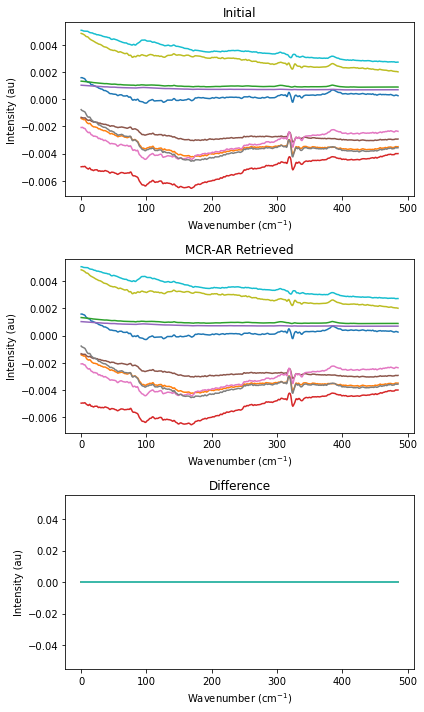

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,10))
plt.subplot(311)
plt.plot(Spectrum.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial')

plt.subplot(312)
plt.plot(mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(313)
plt.plot(Spectrum.T - mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

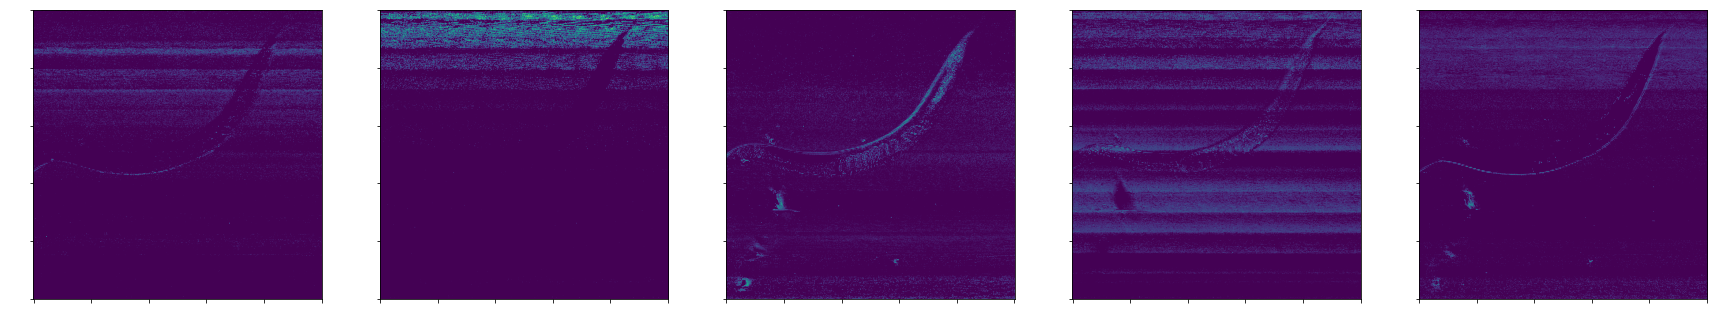

In [8]:
plt.figure(figsize=(30,150))
plt.subplot(151)
plt.imshow(mcrar.C_opt_[:,0].reshape(501,501))
plt.yticks(color="None")
plt.xticks(color="None")
plt.subplot(152)
plt.imshow(mcrar.C_opt_[:,1].reshape(501,501))
plt.yticks(color="None")
plt.xticks(color="None")
plt.subplot(153)
plt.imshow(mcrar.C_opt_[:,2].reshape(501,501))
plt.yticks(color="None")
plt.xticks(color="None")
plt.subplot(154)
plt.imshow(mcrar.C_opt_[:,3].reshape(501,501))
plt.yticks(color="None")
plt.xticks(color="None")
plt.subplot(155)
plt.imshow(mcrar.C_opt_[:,4].reshape(501,501))
plt.yticks(color="None")
plt.xticks(color="None")